<a href="https://colab.research.google.com/github/JaeminKIM-Irene/FC_AI_Track_Learning/blob/main/NLP/tutorial/%5BNLP_realtime%5D1.%20Sentimental_Classification_IMDB.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Sentiment Classification

### Task
* IMDB 영화사이트에서 50000개의 영화평을 가지고 positive/negative인지 구분해보자.
* 데이터 불러오기를 제외한 딥러닝 트레이닝 과정을 직접 구현해보는 것이 목표 입니다.

### Dataset
* [IMDB datasets](https://www.imdb.com/interfaces/)

### Base code
* Dataset: train, val, test로 split
* Input data shape: (`batch_size`, `max_sequence_length`)
* Output data shape: (`batch_size`, 1)
* Architecture:
  * RNN을 이용한 간단한 classification 모델 가이드
  * `Embedding` - `SimpleRNN` - `Dense (with Sigmoid)`
* Training
* Evaluation

### Try some techniques
* Training-epochs 조절
* Change model architectures (Custom model)
  * Use another cells (LSTM, GRU, etc.)
  * Use dropout layers
* Embedding size 조절
  * 또는 one-hot vector로 학습
* Number of words in the vocabulary 변화
* `pad` 옵션 변화
* Data augmentation (if possible)

## 자연어처리에 관한 workflow

The flowchart of the algorithm is roughly:

<img src="https://user-images.githubusercontent.com/11681225/46912373-d2a3a800-cfae-11e8-8201-ef17b65834f5.png" alt="natural_language_flowchart" style="width: 300px;"/>

## Import modules

In [34]:
use_colab = True
assert use_colab in [True, False]

In [35]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [36]:
!pip install torchtext
!pip install portalocker>=2.0.0

In [37]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function
from __future__ import unicode_literals

import os
import time
import shutil
import tarfile

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from IPython.display import clear_output

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from torch.nn.utils.rnn import pad_sequence

from torchtext.datasets import IMDB
from torchtext.data.utils import get_tokenizer
from torchtext.vocab import build_vocab_from_iterator
from torch.utils.data import DataLoader

from collections import Counter, defaultdict

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


## Load Data

* IMDB에서 다운받은 총 50000개의 영화평을 사용합니다.
* `torchtext.dataset`에 이미 잘 가공된 데이터 셋이 있으므로 쉽게 다운받아 사용할 수 있습니다.

In [38]:
# IMDB 데이터셋 로드
train_iter, test_iter = IMDB(split=('train', 'test'))

In [39]:
# train_iter의 길이를 계산합니다.
train_length = sum(1 for _ in train_iter)

# test_iter의 길이를 계산합니다.
test_length = sum(1 for _ in test_iter)

print(f"Train dataset length: {train_length}")
print(f"Test dataset length: {test_length}")

Train dataset length: 25000
Test dataset length: 25000


In [40]:
label_counter = Counter()
for label, _ in train_iter:
    label_counter[label] += 1
print(f"Label Distribution in Training Set: {label_counter}")


Label Distribution in Training Set: Counter({1: 12500, 2: 12500})


### 텍스트 리뷰

* IMDb 데이터의 주요 구성 요소는 영화 리뷰 텍스트입니다. 각 리뷰는 영화에 대한 사용자의 의견을 텍스트 형식으로 포함하고 있습니다. 이 리뷰 텍스트는 모델의 입력으로 사용됩니다.

* IMDb 데이터의 레이블은 각 리뷰에 대한 감정 분류를 나타냅니다. 일반적으로 긍정적인 리뷰는 2로, 부정적인 리뷰는 1으로 레이블링됩니다. 이러한 이진 분류 작업에서 모델은 주어진 리뷰의 감정을 예측하도록 훈련됩니다.

In [41]:
for i, (label, text) in enumerate(train_iter):
    if i >= 5:  # 첫 5개의 샘플만 출력
        break
    print(f"Label: {label}\nText: {text[:200]}...\n")  # 텍스트의 첫 200자만 출력


Label: 1
Text: I rented I AM CURIOUS-YELLOW from my video store because of all the controversy that surrounded it when it was first released in 1967. I also heard that at first it was seized by U.S. customs if it ev...

Label: 1
Text: "I Am Curious: Yellow" is a risible and pretentious steaming pile. It doesn't matter what one's political views are because this film can hardly be taken seriously on any level. As for the claim that ...

Label: 1
Text: If only to avoid making this type of film in the future. This film is interesting as an experiment but tells no cogent story.<br /><br />One might feel virtuous for sitting thru it because it touches ...

Label: 1
Text: This film was probably inspired by Godard's Masculin, féminin and I urge you to see that film instead.<br /><br />The film has two strong elements and those are, (1) the realistic acting (2) the impre...

Label: 1
Text: Oh, brother...after hearing about this ridiculous film for umpteen years all I can think of is that old P

In [42]:
word_counter = Counter()
for _, text in train_iter:
    words = text.split()
    word_counter.update(words)

print(f"Total number of words: {sum(word_counter.values())}")
print(f"Unique words: {len(word_counter)}")
print(f"Most common words: {word_counter.most_common(10)}")


Total number of words: 5844680
Unique words: 280617
Most common words: [('the', 287032), ('a', 155096), ('and', 152664), ('of', 142972), ('to', 132568), ('is', 103229), ('in', 85580), ('I', 65973), ('that', 64560), ('this', 57199)]


### 단어 토큰화 (Word Tokenization):

* 단어 토큰화는 텍스트를 단어 단위로 나누는 것입니다. 예를 들어, "Hello, how are you?"라는 문장은 다음과 같이 단어로 토큰화될 수 있습니다: ["Hello", ",", "how", "are", "you", "?"]

In [43]:
tokenizer = get_tokenizer('basic_english')

tokenized_texts = []
labels = []
for label, text in train_iter:
    tokens = tokenizer(text)
    tokenized_texts.append(tokens)
    labels.append(label-1)

test_tokenized_texts = []
test_labels = []
for label, text in test_iter:
    tokens = tokenizer(text)
    test_tokenized_texts.append(tokens)
    test_labels.append(label-1)


In [44]:
for i in range(5):
    print(f"Label: {labels[i]}")
    print(f"Tokens: {tokenized_texts[i][:15]}")  # 첫 15개 토큰만 출력
    print()


Label: 0
Tokens: ['i', 'rented', 'i', 'am', 'curious-yellow', 'from', 'my', 'video', 'store', 'because', 'of', 'all', 'the', 'controversy', 'that']

Label: 0
Tokens: ['i', 'am', 'curious', 'yellow', 'is', 'a', 'risible', 'and', 'pretentious', 'steaming', 'pile', '.', 'it', 'doesn', "'"]

Label: 0
Tokens: ['if', 'only', 'to', 'avoid', 'making', 'this', 'type', 'of', 'film', 'in', 'the', 'future', '.', 'this', 'film']

Label: 0
Tokens: ['this', 'film', 'was', 'probably', 'inspired', 'by', 'godard', "'", 's', 'masculin', ',', 'féminin', 'and', 'i', 'urge']

Label: 0
Tokens: ['oh', ',', 'brother', '.', '.', '.', 'after', 'hearing', 'about', 'this', 'ridiculous', 'film', 'for', 'umpteen', 'years']



### 어휘 구축

* 가장 일반적인 방법은 상위 N개의 빈도가 높은 토큰을 선택하여 어휘를 구축하는 것입니다. 이렇게 선택된 토큰들은 어휘의 일부로 포함되며, 각 토큰에 고유한 정수 인덱스를 할당합니다. 예를 들어, 상위 10,000개의 토큰을 선택하고 각각에 0부터 9,999까지의 인덱스를 할당할 수 있습니다.

* 종종 시작 토큰(<sos>), 종료 토큰(<eos>), 패딩 토큰(<pad>), 알 수 없는 토큰(<unk>)과 같은 특수 토큰들을 어휘에 추가합니다. 이러한 특수 토큰들은 모델 훈련과 시퀀스 처리에서 유용합니다.

* 어휘의 크기는 선택한 상위 N개의 토큰과 특수 토큰의 합으로 결정됩니다. 이 크기는 모델의 입력 및 출력 차원에 영향을 미칩니다.

In [45]:
def build_vocab_with_padding_and_unk(tokenized_texts, padding_token='<pad>', unk_token='<unk>'):
    # 모든 토큰의 빈도수를 계산합니다.
    token_freqs = Counter(token for text in tokenized_texts for token in text)

    # 어휘 사전을 구축합니다. padding_token과 unk_token을 각각 0번, 1번 인덱스에 추가합니다.
    vocab = {padding_token: 0, unk_token: 1}
    vocab.update({token: idx + 2 for idx, (token, _) in enumerate(token_freqs.items())})

    return vocab

all_tokenized_text = tokenized_texts + test_tokenized_texts
print(all_tokenized_text[:10])
vocab = build_vocab_with_padding_and_unk(all_tokenized_text)


[['i', 'rented', 'i', 'am', 'curious-yellow', 'from', 'my', 'video', 'store', 'because', 'of', 'all', 'the', 'controversy', 'that', 'surrounded', 'it', 'when', 'it', 'was', 'first', 'released', 'in', '1967', '.', 'i', 'also', 'heard', 'that', 'at', 'first', 'it', 'was', 'seized', 'by', 'u', '.', 's', '.', 'customs', 'if', 'it', 'ever', 'tried', 'to', 'enter', 'this', 'country', ',', 'therefore', 'being', 'a', 'fan', 'of', 'films', 'considered', 'controversial', 'i', 'really', 'had', 'to', 'see', 'this', 'for', 'myself', '.', 'the', 'plot', 'is', 'centered', 'around', 'a', 'young', 'swedish', 'drama', 'student', 'named', 'lena', 'who', 'wants', 'to', 'learn', 'everything', 'she', 'can', 'about', 'life', '.', 'in', 'particular', 'she', 'wants', 'to', 'focus', 'her', 'attentions', 'to', 'making', 'some', 'sort', 'of', 'documentary', 'on', 'what', 'the', 'average', 'swede', 'thought', 'about', 'certain', 'political', 'issues', 'such', 'as', 'the', 'vietnam', 'war', 'and', 'race', 'issues',

In [46]:
len(vocab)

147158

In [47]:
vocab

{'<pad>': 0,
 '<unk>': 1,
 'i': 2,
 'rented': 3,
 'am': 4,
 'curious-yellow': 5,
 'from': 6,
 'my': 7,
 'video': 8,
 'store': 9,
 'because': 10,
 'of': 11,
 'all': 12,
 'the': 13,
 'controversy': 14,
 'that': 15,
 'surrounded': 16,
 'it': 17,
 'when': 18,
 'was': 19,
 'first': 20,
 'released': 21,
 'in': 22,
 '1967': 23,
 '.': 24,
 'also': 25,
 'heard': 26,
 'at': 27,
 'seized': 28,
 'by': 29,
 'u': 30,
 's': 31,
 'customs': 32,
 'if': 33,
 'ever': 34,
 'tried': 35,
 'to': 36,
 'enter': 37,
 'this': 38,
 'country': 39,
 ',': 40,
 'therefore': 41,
 'being': 42,
 'a': 43,
 'fan': 44,
 'films': 45,
 'considered': 46,
 'controversial': 47,
 'really': 48,
 'had': 49,
 'see': 50,
 'for': 51,
 'myself': 52,
 'plot': 53,
 'is': 54,
 'centered': 55,
 'around': 56,
 'young': 57,
 'swedish': 58,
 'drama': 59,
 'student': 60,
 'named': 61,
 'lena': 62,
 'who': 63,
 'wants': 64,
 'learn': 65,
 'everything': 66,
 'she': 67,
 'can': 68,
 'about': 69,
 'life': 70,
 'particular': 71,
 'focus': 72,
 'he

### 토크나이징된 데이터와 vocab index 확인

In [48]:
def tokenize_and_index(texts, vocab):
    indexed_texts = []
    for text in texts:
        indexed_text = [vocab[token] if token in vocab else vocab['<unk>'] for token in text]
        indexed_texts.append(indexed_text)
    return indexed_texts

indexed_texts = tokenize_and_index(tokenized_texts, vocab)
test_indexed_texts = tokenize_and_index(test_tokenized_texts, vocab)


In [49]:
indexed_texts[0]

[2,
 3,
 2,
 4,
 5,
 6,
 7,
 8,
 9,
 10,
 11,
 12,
 13,
 14,
 15,
 16,
 17,
 18,
 17,
 19,
 20,
 21,
 22,
 23,
 24,
 2,
 25,
 26,
 15,
 27,
 20,
 17,
 19,
 28,
 29,
 30,
 24,
 31,
 24,
 32,
 33,
 17,
 34,
 35,
 36,
 37,
 38,
 39,
 40,
 41,
 42,
 43,
 44,
 11,
 45,
 46,
 47,
 2,
 48,
 49,
 36,
 50,
 38,
 51,
 52,
 24,
 13,
 53,
 54,
 55,
 56,
 43,
 57,
 58,
 59,
 60,
 61,
 62,
 63,
 64,
 36,
 65,
 66,
 67,
 68,
 69,
 70,
 24,
 22,
 71,
 67,
 64,
 36,
 72,
 73,
 74,
 36,
 75,
 76,
 77,
 11,
 78,
 79,
 80,
 13,
 81,
 82,
 83,
 69,
 84,
 85,
 86,
 87,
 88,
 13,
 89,
 90,
 91,
 92,
 86,
 22,
 13,
 93,
 94,
 24,
 22,
 95,
 96,
 97,
 91,
 98,
 99,
 11,
 100,
 69,
 101,
 102,
 79,
 103,
 40,
 67,
 104,
 105,
 106,
 73,
 59,
 107,
 40,
 108,
 40,
 91,
 109,
 110,
 24,
 80,
 111,
 112,
 69,
 2,
 4,
 5,
 54,
 15,
 113,
 114,
 115,
 40,
 38,
 19,
 46,
 116,
 24,
 48,
 40,
 13,
 105,
 91,
 117,
 118,
 119,
 120,
 91,
 121,
 95,
 40,
 122,
 123,
 17,
 124,
 31,
 125,
 126,
 127,
 76,
 128,
 129,
 13

In [50]:
def index_to_word(indexed_texts, vocab):
    # vocab의 역매핑을 생성합니다. 인덱스를 단어로 매핑합니다.
    reverse_vocab = {index: word for word, index in vocab.items()}

    # 인덱스 시퀀스를 단어 시퀀스로 변환합니다.
    word_texts = []
    for indexed_text in indexed_texts:
        word_text = [reverse_vocab[index] for index in indexed_text]
        word_texts.append(word_text)
    return word_texts


In [51]:
original_texts = index_to_word([indexed_texts[0]], vocab)
original_texts

[['i',
  'rented',
  'i',
  'am',
  'curious-yellow',
  'from',
  'my',
  'video',
  'store',
  'because',
  'of',
  'all',
  'the',
  'controversy',
  'that',
  'surrounded',
  'it',
  'when',
  'it',
  'was',
  'first',
  'released',
  'in',
  '1967',
  '.',
  'i',
  'also',
  'heard',
  'that',
  'at',
  'first',
  'it',
  'was',
  'seized',
  'by',
  'u',
  '.',
  's',
  '.',
  'customs',
  'if',
  'it',
  'ever',
  'tried',
  'to',
  'enter',
  'this',
  'country',
  ',',
  'therefore',
  'being',
  'a',
  'fan',
  'of',
  'films',
  'considered',
  'controversial',
  'i',
  'really',
  'had',
  'to',
  'see',
  'this',
  'for',
  'myself',
  '.',
  'the',
  'plot',
  'is',
  'centered',
  'around',
  'a',
  'young',
  'swedish',
  'drama',
  'student',
  'named',
  'lena',
  'who',
  'wants',
  'to',
  'learn',
  'everything',
  'she',
  'can',
  'about',
  'life',
  '.',
  'in',
  'particular',
  'she',
  'wants',
  'to',
  'focus',
  'her',
  'attentions',
  'to',
  'making',
 

### Padding and truncating data using pad sequences
* 전부 길이가 다른 리뷰들의 길이를 통일해주자

In [52]:
def calculate_length_percentages(sequences, max_length=256):
    # 각 시퀀스의 길이를 계산합니다.
    lengths = [len(seq) for seq in sequences]

    # max_length보다 짧은 시퀀스의 수를 세어 비율을 계산합니다.
    num_shorter = sum(1 for length in lengths if length <= max_length)
    percentage = (num_shorter / len(sequences)) * 100

    return percentage

In [53]:
percentage = calculate_length_percentages(indexed_texts, max_length=256)
print(f"Percentage of sequences shorter than or equal to max_length: {percentage}%")

Percentage of sequences shorter than or equal to max_length: 63.756%


In [54]:
def pad_sequences(sequences, max_len=None, padding_value=0):
    # 최대 길이를 설정합니다. 만약 max_len이 제공되지 않으면, 시퀀스 중 가장 긴 것의 길이를 사용합니다.
    if max_len is None:
        max_len = max(len(seq) for seq in sequences)

    # 패딩된 시퀀스의 배열을 초기화합니다.
    padded_sequences = np.full((len(sequences), max_len), padding_value)

    # 각 시퀀스를 패딩하여 배열에 넣습니다.
    for i, seq in enumerate(sequences):
        padded_sequences[i, -len(seq):] = seq[:max_len]

    return padded_sequences


In [55]:
padded_train_texts = pad_sequences(indexed_texts, max_len=256)
print(padded_train_texts.shape)

padded_test_texts = pad_sequences(test_indexed_texts, max_len=256)
print(padded_test_texts.shape)

(25000, 256)
(25000, 256)


#### Padding data 출력

In [56]:
padded_train_texts[3]

array([  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,  38, 156,  19, 340, 341,  29, 342, 124,  31,
       343,  40, 344,  91,   2, 345, 277,  36,  50,  15, 156, 346,  24,
        13, 156, 104, 347, 348, 349,  91, 224, 119,  40, 174, 350, 178,
        13, 351, 352, 174, 353, 178,  13, 354,  40, 355, 144,  40, 356,
        24, 357,   6,  15,  40,  80, 358, 112, 359,  54,  13, 360, 361,
        11, 362,  24,  62, 363, 104,  36, 166, 359, 364, 365,  2

### Dataset 구성

In [57]:
from torch.utils.data import DataLoader, Dataset

class TextDataset(Dataset):
    def __init__(self, texts, labels):
        self.texts = texts
        self.labels = labels

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        return torch.tensor(self.texts[idx], dtype=torch.long), torch.tensor(self.labels[idx], dtype=torch.float)

# 훈련 및 테스트 데이터셋 생성
train_dataset = TextDataset(padded_train_texts, labels)
test_dataset = TextDataset(padded_test_texts, test_labels)

# DataLoader 생성
batch_size=32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)


In [58]:
for d, l in train_loader:
    print(d.size(), l.size())
    break

for d, l in test_loader:
    print(d.size(), l.size())
    break

torch.Size([32, 256]) torch.Size([32])
torch.Size([32, 256]) torch.Size([32])


## Build the model
### Embedding layer

* embedding-layer는 전체 vocabulary의 갯수(num_words)로 이루어진 index가 `embedding_size`의 *dense vector* 로 변환되는 과정입니다.

In [59]:
class LSTMModel(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, output_dim, n_layers,
                 bidirectional, dropout):
        super(LSTMModel, self).__init__()

        # 임베딩 레이어
        self.embedding = nn.Embedding(vocab_size, embedding_dim)

        # LSTM 레이어
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, num_layers=n_layers,
                            bidirectional=bidirectional, dropout=dropout, batch_first=True)

        # Fully-connected 레이어
        self.fc = nn.Linear(hidden_dim * 2 if bidirectional else hidden_dim, output_dim)

        # 드롭아웃
        self.dropout = nn.Dropout(dropout)

    def forward(self, text):
        # text = [batch size, sent len]

        # 임베딩 적용
        embedded = self.dropout(self.embedding(text))
        # embedded = [batch size, sent len, emb dim]

        # LSTM 적용
        output, (hidden, cell) = self.lstm(embedded)
        # output = [batch size, sent len, hid dim * num directions]
        # hidden/cell = [num layers * num directions, batch size, hid dim]

        # 최종 출력을 위한 hidden state 선택
        if self.lstm.bidirectional:
            hidden = self.dropout(torch.cat((hidden[-2,:,:], hidden[-1,:,:]), dim=1))
        else:
            hidden = self.dropout(hidden[-1,:,:])
        # hidden = [batch size, hid dim * num directions]

        return self.fc(hidden)


## Setup hyper-parameters

In [60]:
INPUT_DIM = len(vocab)  # vocab_size
EMBEDDING_DIM = 64      # 임베딩 차원
HIDDEN_DIM = 256        # LSTM hidden 차원
OUTPUT_DIM = 1          # 출력 차원 (이진 분류의 경우 1)
N_LAYERS = 2            # LSTM 레이어 수
BIDIRECTIONAL = True    # 양방향 LSTM 사용 여부
DROPOUT = 0.5           # 드롭아웃 비율

model = LSTMModel(INPUT_DIM, EMBEDDING_DIM, HIDDEN_DIM, OUTPUT_DIM, N_LAYERS,
                  BIDIRECTIONAL, DROPOUT)


## Train the model

In [61]:
# 손실 함수 및 옵티마이저 인스턴스화
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters())

# 장치 설정 (GPU 사용 가능한 경우)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)
criterion = criterion.to(device)

In [62]:
def train(model, iterator, optimizer, criterion):
    epoch_loss = 0
    model.train()
    for data, label in iterator:
        data, label = data.to(device), label.to(device)

        optimizer.zero_grad()
        predictions = model(data)
        loss = criterion(predictions, label.unsqueeze(-1))

        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
    return epoch_loss / len(iterator)

def evaluate(model, iterator, criterion):
    epoch_loss = 0
    model.eval()
    with torch.no_grad():
        for data, label in iterator:
            data, label = data.to(device), label.to(device)

            predictions = model(data)
            loss = criterion(predictions, label.unsqueeze(-1))
            epoch_loss += loss.item()
    return epoch_loss / len(iterator)


In [30]:
N_EPOCHS = 10
train_losses = []
valid_losses = []

for epoch in range(N_EPOCHS):
    train_loss = train(model, train_loader, optimizer, criterion)
    valid_loss = evaluate(model, test_loader, criterion)

    train_losses.append(train_loss)
    valid_losses.append(valid_loss)

    print(f'Epoch: {epoch+1}, Train Loss: {train_loss:.3f}, Val. Loss: {valid_loss:.3f}')


Epoch: 1, Train Loss: 0.691, Val. Loss: 0.685
Epoch: 2, Train Loss: 0.690, Val. Loss: 0.691
Epoch: 3, Train Loss: 0.685, Val. Loss: 0.686
Epoch: 4, Train Loss: 0.618, Val. Loss: 0.476
Epoch: 5, Train Loss: 0.452, Val. Loss: 0.393
Epoch: 6, Train Loss: 0.367, Val. Loss: 0.341
Epoch: 7, Train Loss: 0.319, Val. Loss: 0.326
Epoch: 8, Train Loss: 0.284, Val. Loss: 0.377
Epoch: 9, Train Loss: 0.258, Val. Loss: 0.361
Epoch: 10, Train Loss: 0.232, Val. Loss: 0.348


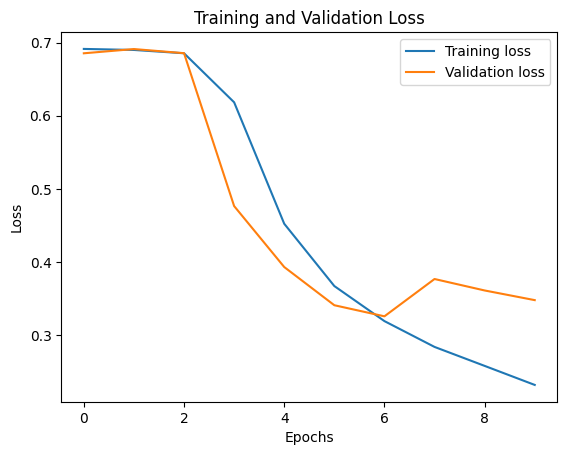

In [31]:
plt.plot(train_losses, label='Training loss')
plt.plot(valid_losses, label='Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


### Model Evaluate

In [32]:
def calculate_accuracy(model, loader, device):
    model.eval()  # 모델을 평가 모드로 설정
    correct = 0
    total = 0

    with torch.no_grad():  # 그래디언트 계산 비활성화
        for texts, labels in loader:
            texts, labels = texts.to(device), labels.to(device)
            outputs = model(texts)
            # 출력에서 가장 높은 값을 가진 인덱스가 예측값입니다 (이진 분류의 경우 시그모이드 적용 후 임계값 설정)
            predictions = torch.round(torch.sigmoid(outputs.squeeze()))
            correct += (predictions == labels).sum().item()
            total += labels.size(0)

    accuracy = correct / total
    return accuracy


In [33]:
test_accuracy = calculate_accuracy(model, test_loader, device)
print(f'Test Accuracy: {test_accuracy * 100:.2f}%')


Test Accuracy: 86.92%
